  ## Author
  Joel Bandstra  
  10/10/2023  
  
  ## Purpose
  Perform global fitting of a first-order reaction network model to a series of experiments where time-series concentration data were collected on dissolved chlorinated ethenes reacting with several forms and doses of zero valent iron. 


## Import libraries needed and read data files

In [5]:
# dependencies
%matplotlib inline
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.linalg import expm

# data import
## S = 0.00
file_mZVIbm_0_00 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.00)-mZVIbm-background corrected-2021.03.10-4places.xlsx'
dict_mZVIbm_0_00 = pd.read_excel(file_mZVIbm_0_00, sheet_name=None)
sheet_names_0_00 = list(dict_mZVIbm_0_00.keys())[:-1]
## S = 0.02
file_mZVIbm_0_02 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.02)-mZVIbm-background corrected-2023.09.25-4places.xlsx'
dict_mZVIbm_0_02 = pd.read_excel(file_mZVIbm_0_02, sheet_name=None)
sheet_names_0_02 = list(dict_mZVIbm_0_02.keys())[:-1]
## S = 0.05
file_mZVIbm_0_05 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.05)-mZVIbm-background corrected-2023.09.25-4places.xlsx'
dict_mZVIbm_0_05 = pd.read_excel(file_mZVIbm_0_05, sheet_name=None)
sheet_names_0_05 = list(dict_mZVIbm_0_05.keys())[:-1]
## S = 0.10
file_mZVIbm_0_10 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.10)-mZVIbm-background corrected-2021.01.13b-4places.xlsx'
dict_mZVIbm_0_10 = pd.read_excel(file_mZVIbm_0_10, sheet_name=None)
sheet_names_0_10 = list(dict_mZVIbm_0_10.keys())[:-1]
## S = 0.20
file_mZVIbm_0_20 = r'PCE_data\Data on 10.10.23\Dechlorination data S(0.20)-mZVIbm-background corrected-2023.09.25-4places.xlsx'
dict_mZVIbm_0_20 = pd.read_excel(file_mZVIbm_0_20, sheet_name=None)
sheet_names_0_20 = list(dict_mZVIbm_0_20.keys())[:-1]



  ## Theoretical background 
  
  The experimental data consist of several different initial ethenes (e.g., PCE, TCE, DCE's etc.) and both the reactant and several intermediates/products were monitored over time.  

  The reaction scheme shown below represents the network of first order reactions included in the model.  

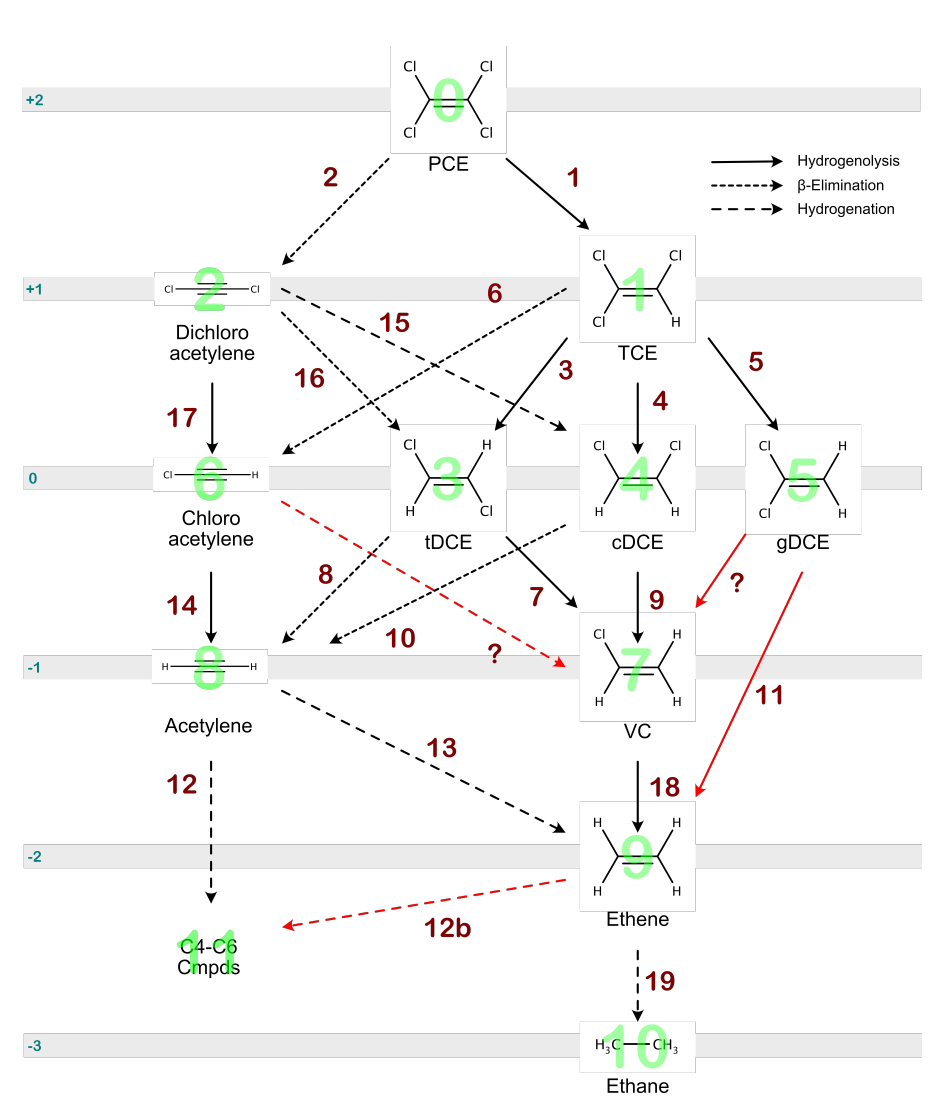

  ## Model Formulation
  Assuming that all of the reactions represented above are first-order and irreversible and that a first-order, reversible partitioning process accounts for loss of mass balance, a system of ODE's can be written as:  
  
  $\begin{aligned}
\frac{dC_0}{dt} &= -(k_1 + k_2 + k_{Lf})\cdot C_0 + k_{Lb} \cdot C_{12}\\
\frac{dC_1}{dt} &= +k_1 \cdot C_0 - (k_3 + k_4 + k_5 + k_6 + k_{Lf}) \cdot C_1 + k_{Lb} \cdot C_{13}\\
\frac{dC_2}{dt} &= +k_2 \cdot C_0 - (k_{15} + k_{16} + k_{17} + k_{Lf}) \cdot C_2 + k_{Lb} \cdot C_{14}\\
\frac{dC_3}{dt} &= +k_3 \cdot C_1 + k_{16} \cdot C_2 - (k_7 + k_8 + k_{Lf}) \cdot C_3 + k_{Lb} \cdot C_{15}\\
\frac{dC_4}{dt} &= +k_4 \cdot C_1 + k_{15} \cdot C_2 - (k_9 + k_{10} + k_{Lf}) \cdot C_4 + k_{Lb} \cdot C_{16}\\
\frac{dC_5}{dt} &= +k_5 \cdot C_1 - (k_{11} + k_{11b} + k_{Lf}) \cdot C_5 + k_{Lb} \cdot C_{17} \\
\frac{dC_6}{dt} &= +k_6 \cdot C_1 + k_{17} \cdot C_2 -(k_{13b} + k_{14} + k_{Lf}) \cdot C_6 + k_{Lb} \cdot C_{18} \\
\frac{dC_7}{dt} &= +k_7 \cdot C_3 + k_9 \cdot C_4 + k_{11b} \cdot C_5 + k_{13b} \cdot C_6 - (k_{18} + k_{Lf}) \cdot C_7 + k_{Lb} \cdot C_{19} \\
\frac{dC_8}{dt} &= +k_8 \cdot C_3 + k_{10} \cdot C_4 + k_{14} \cdot C_6 - (k_{12} + k_{13} + k_{13c} + k_{Lf}) \cdot C_8 + k_{Lb} \cdot C_{20} \\
\frac{dC_9}{dt} &= +k_{11} \cdot C_5 + k_{18} \cdot C_7 + k_{13} \cdot C_8 - (k_{12b} + k_{19} + k_{Lf}) \cdot C_9 + k_{Lb} \cdot C_{21} \\
\frac{dC_{10}}{dt} &= +k_{13c} \cdot C_8 + k_{19} \cdot C_9 - k_{Lf} \cdot C_{10} + k_{Lb} \cdot C_{22} \\
\frac{dC_{11}}{dt} &= +k_{12} \cdot C_8 + k_{12b} \cdot C_9 - k_{Lf} \cdot C_{11} + k_{Lb} \cdot C_{23} \\
\frac{dC_{12}}{dt} &= +k_{Lf} \cdot C_0 - k_{Lb} \cdot C_{12} \\
\frac{dC_{13}}{dt} &= +k_{Lf} \cdot C_1 - k_{Lb} \cdot C_{13} \\
\frac{dC_{14}}{dt} &= +k_{Lf} \cdot C_2 - k_{Lb} \cdot C_{14} \\
\frac{dC_{15}}{dt} &= +k_{Lf} \cdot C_3 - k_{Lb} \cdot C_{15} \\
\frac{dC_{16}}{dt} &= +k_{Lf} \cdot C_4 - k_{Lb} \cdot C_{16} \\
\frac{dC_{17}}{dt} &= +k_{Lf} \cdot C_5 - k_{Lb} \cdot C_{17} \\
\frac{dC_{18}}{dt} &= +k_{Lf} \cdot C_6 - k_{Lb} \cdot C_{18} \\
\frac{dC_{19}}{dt} &= +k_{Lf} \cdot C_7 - k_{Lb} \cdot C_{19} \\
\frac{dC_{20}}{dt} &= +k_{Lf} \cdot C_8 - k_{Lb} \cdot C_{20} \\
\frac{dC_{21}}{dt} &= +k_{Lf} \cdot C_9 - k_{Lb} \cdot C_{21} \\
\frac{dC_{22}}{dt} &= +k_{Lf} \cdot C_{10} - k_{Lb} \cdot C_{22} \\
\frac{dC_{23}}{dt} &= +k_{Lf} \cdot C_{11} - k_{Lb} \cdot C_{23} \\
  \end{aligned}$

  where concentration and rate constant numbering scheme is represented in reaction network diagram and $k_{Lf}$ and $k_{Lb}$ represent rate forward and backward rate constants, respectively, for a kinetic partitioning process intended to unbias fitting results in the face of incomplete mass balance (presumably due to some combination of partitioning processes out of the aqeuous phase).  

  ## Matrix Formulation
  The kinetic model above can be formulated in matrix form as:  
  $
\dot{C} = \vec{k} \cdot \vec{C}
  $

  where $\vec{C}$ is the vector of concentrations, $\dot{C}$ is the time derivtive of the concentrations, and $\vec{k}$ is a matrix of rate constant terms given by:
  
  $
\vec{k} = 
  $

  
  $
\tiny \begin{matrix}
-(k_1 + k_2 + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
k_1 & -(k_3 + k_4 + k_5 + k_6 + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
k_2 & 0 & -(k_{15} + k_{16} + k_{17} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_3 & k_{16} & -(k_7 + k_8 + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_4 & k_{15} & 0 & -(k_9 + k_{10} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_5 & 0 & 0 & 0 & -(k_{11} + k_{11b} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_6 & k_{17} & 0 & 0 & 0 & -(k_{13b} + k_{14} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_7 & k_9 & k_{11b} & k_{13b} & -(k_{18} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_8 & k_{10} & 0 & k_{14} & 0 & -(k_{12} + k_{13} + k_{13c} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & k_{11} & 0 & k_{18} & k_{13} & -(k_{12b} + k_{19} + k_{Lf}) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{13c} & k_{19} & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{12} & k_{12b} & 0 & -k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lb} \\
k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb} & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & k_{Lf} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -k_{Lb}
\end{matrix}
  $


## Solution method
The system of ODE's expressed above can be solved using the matrix exponential function along with a suitable initial condition. This approach is exemplified in the local fits of degredation data with unsulfidated ZVI.

## Local Fits of S = 0.00 data